## Q1

In [56]:
import pandas as pd

ames_housing = pd.read_csv("../datasets/house_prices.csv", na_values="?")
target_name = "SalePrice"
data = ames_housing.drop(columns=target_name)
target = ames_housing[target_name]

In [57]:
numerical_features = [
    "LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2",
    "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "LowQualFinSF",
    "GrLivArea", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces",
    "GarageCars", "GarageArea", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch",
    "3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal",
]

data_numerical = data[numerical_features]

In [58]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline

linear_regression = make_pipeline(StandardScaler(), SimpleImputer(), LinearRegression())
tree = make_pipeline(SimpleImputer(), DecisionTreeRegressor(random_state=0))

cv_results_linear = cross_validate(linear_regression, data_numerical, target,
                                   cv=10, return_estimator=True, n_jobs=2)
cv_results_tree = cross_validate(tree, data_numerical, target,
                                 cv=10, return_estimator=True, n_jobs=2)

In [59]:
print(f"Linear Regression test score: {cv_results_linear['test_score'].mean():.2f}\n"
      f"Decision Tree test score: {cv_results_tree['test_score'].mean():.2f}")

Linear Regression test score: 0.72
Decision Tree test score: 0.62


## Q2

In [61]:
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid = {"max_depth": np.arange(1, 15, 1)}
tree_reg = make_pipeline(SimpleImputer(), GridSearchCV(DecisionTreeRegressor(),
                                                       param_grid=param_grid,
                                                       cv=10))
tree_reg.fit(data_numerical, target)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('gridsearchcv',
                 GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
                              param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])}))])

In [63]:
tree_reg['gridsearchcv'].best_params_

{'max_depth': 6}

## Q2 Answer

In [64]:
import numpy as np
from sklearn.model_selection import GridSearchCV

params = {"decisiontreeregressor__max_depth": np.arange(1, 15)}
search = GridSearchCV(tree, params, cv=10)
cv_results_tree_optimal_depth = cross_validate(
    search, data_numerical, target, cv=10, return_estimator=True, n_jobs=2,
)
cv_results_tree_optimal_depth["test_score"].mean()

0.6976647456891891

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='max depth'>

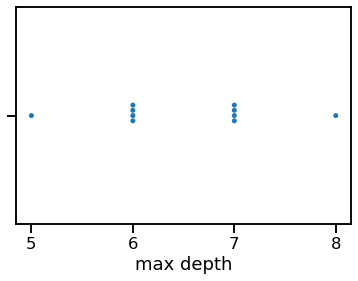

In [65]:
import seaborn as sns
sns.set_context("talk")

max_depth = [
    estimator.best_params_["decisiontreeregressor__max_depth"]
    for estimator in cv_results_tree_optimal_depth["estimator"]
]
max_depth = pd.Series(max_depth, name="max depth")
sns.swarmplot(max_depth)

## Q3

In [77]:
tree = make_pipeline(SimpleImputer(), DecisionTreeRegressor(max_depth=6, random_state=0))
cv_results = cross_validate(tree, data_numerical, target, cv=10)
cv_results["test_score"].mean()

0.696213291075248

## Q4

In [80]:
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)
numerical_columns = numerical_columns_selector(data)
categorical_columns = categorical_columns_selector(data)

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('standard-scaler', numerical_preprocessor, numerical_columns)
])

tree = make_pipeline(preprocessor, SimpleImputer(), DecisionTreeRegressor(random_state=0))
cv_results = cross_validate(tree, data, target, cv=10)
cv_results["test_score"].mean()

0.7254999711936401

## Q4 Answer

In [81]:
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OrdinalEncoder

categorical_processor = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
)
numerical_processor = SimpleImputer()


preprocessor = make_column_transformer(
    (categorical_processor, selector(dtype_include=object)),
    (numerical_processor, selector(dtype_exclude=object))
)
tree = make_pipeline(preprocessor, DecisionTreeRegressor(random_state=0))

In [82]:
cv_results = cross_validate(
    tree, data, target, cv=10, return_estimator=True, n_jobs=2
)
cv_results["test_score"].mean()

0.7422751120581628